## Initializing

In [1]:
pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import healpy as hp
import schnell as snl
import matplotlib.pyplot as plt
from scipy.integrate import quad

import seaborn

from matplotlib import rc
rc('font', **{'family': 'sans-serif',
              'sans-serif': ['Helvetica']})
rc('text', usetex=False)

lisa_old = [snl.LISADetector(i, is_L5Gm=True) for i in range(3)]
lisa = [snl.LISADetector(i, is_L5Gm=False) for i in range(3)]
alia = [snl.ALIADetector(i) for i in range(3)]
lisalia = [snl.LISAandALIADetector(i) for i in range(6)]
twolisas = [snl.TwoLISADetector(i) for i in range(6)]
star = [snl.BBOStarDetector(i) for i in range(6)]
freq_low = np.geomspace(1e-4, 1, 100)
freq_low_precise = np.geomspace(1e-4, 1, 201)

from datetime import datetime
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Run of {}".format(current_time))

Run of 14:51:15


In [4]:
t_obs = 4
f_ref = 1E-2
nside = 64

npix = hp.nside2npix(nside)
theta, phi = hp.pix2ang(nside, np.arange(npix))
f_obs = 1e-2

#dets = [snl.ALIADetector(i) for i in range(3)]
#rho = snl.NoiseCorrelationLISA(dets[0])
rhoLO = snl.NoiseCorrelationLISA(lisa_old[0])
rhoL = snl.NoiseCorrelationLISA(lisa[0])
rhoA = snl.NoiseCorrelationLISAlike(alia[0])
rhoLA = snl.NoiseCorrelationLISALIA(lisalia[0])
rhoTL = snl.NoiseCorrelationTwoLISA(twolisas[0])

mcLO = snl.MapCalculator(lisa_old, f_pivot=f_ref,
                       corr_matrix=rhoLO)
mcL = snl.MapCalculator(lisa, f_pivot=f_ref,
                       corr_matrix=rhoL)
mcA = snl.MapCalculator(alia, f_pivot=f_ref,
                       corr_matrix=rhoA)
mcLA = snl.MapCalculator(lisalia, f_pivot=f_ref,
                       corr_matrix=rhoLA)
mcTL = snl.MapCalculator(twolisas, f_pivot=f_ref,
                       corr_matrix=rhoTL)

"""mcS = snl.MapCalculator(star, f_pivot=f_ref,
                       corr_matrix=None)"""

freqs = np.geomspace(1E-4, 0.2, 1001)
obs_time = t_obs * 365 * 24 * 3600

obs_time_T = 4 * 365*24*3600
freqs_T = np.geomspace(1e-4, 1, 101)
nside_T = 32

## Map of $\gamma$ function

In [6]:
gamma = mcTL.get_antenna(i=0, j=1, t=0., f=1e-2, theta=theta, phi=phi, inc_baseline=False)
ant = mcTL.get_antenna(i=0, j=1, t=0., f=1e-2, theta=theta, phi=phi, inc_baseline=True)
expfac = ant / gamma

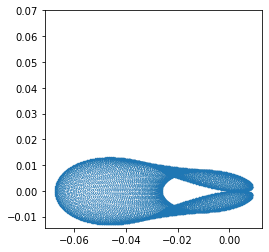

In [42]:
plt.plot(gamma.real, gamma.imag, '.', markersize=0.25)
plt.axis('square')
plt.show();
#hp.mollview(np.min(gamma.real / gamma.imag, 100 * np.ones_like(gamma)))
#hp.mollview(gamma.imag)

(0.0, 5.0)

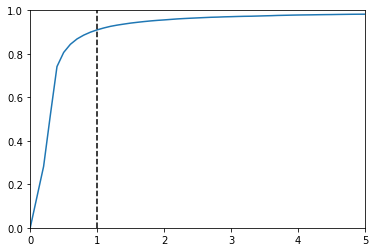

In [11]:
"""
fact = np.abs(gamma.imag) < 0.5 * np.abs(gamma.real)
tot = len(fact)
vals, count = np.unique(fact, return_counts=True)
print(f"Total points : {len(fact)}")
print(f'Rate of success : {dict(zip(vals, count))[True] / tot}')
"""
def count_succ(arr):
    vals, count = np.unique(arr, return_counts=True)
    try:
        return dict(zip(vals, count))[True] / len(arr)
    except:
        return 0

plt.plot(np.arange(51) / 10, [count_succ(np.abs(gamma.imag) < i/10 * np.abs(gamma.real)) for i in range(51)])
plt.plot([1,1], [0, 1], 'k--')
plt.ylim(0, 1)
plt.xlim(0, 5)

In [13]:
hf = snl.GroundDetector('Hanford', 46.4, -119.4, 171.8, 'plots/data/aLIGO.txt')
lv = snl.GroundDetector('Livingstone', 30.7, -90.8, 243.0, 'plots/data/aLIGO.txt')
mc = snl.MapCalculator([hf, lv], f_pivot=63., spectral_index=2./3.)

In [14]:
gammaE = mc.get_antenna(i=0, j=1, t=0., f=1e-2, theta=theta, phi=phi, inc_baseline=False)
antE = mc.get_antenna(i=0, j=1, t=0., f=1e-2, theta=theta, phi=phi, inc_baseline=True)
expfacE = antE / gammaE

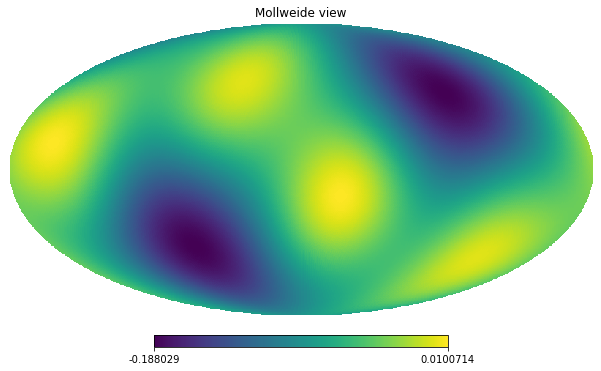

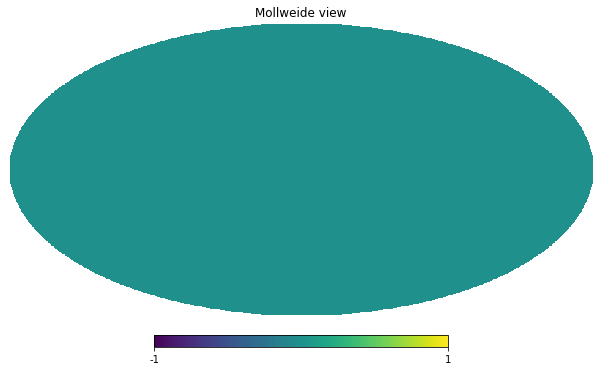

In [15]:
hp.mollview(gammaE.real)
hp.mollview(gammaE.imag)

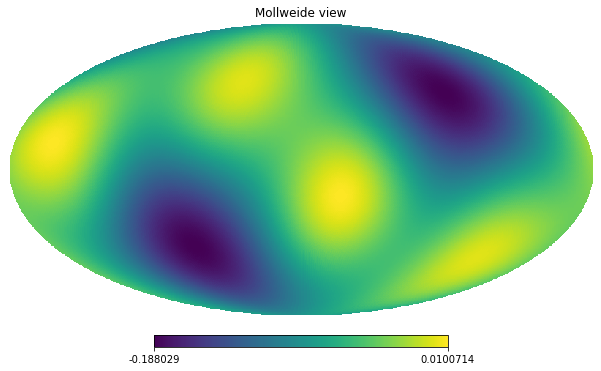

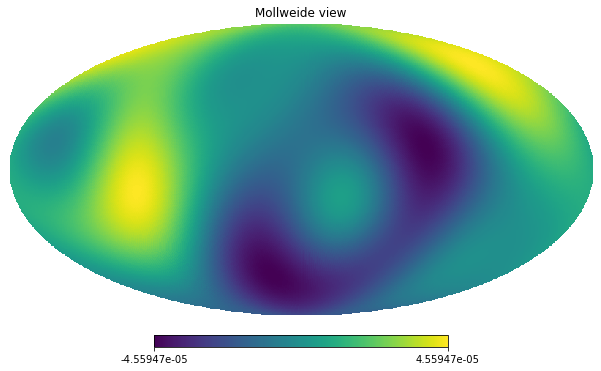

In [24]:
hp.mollview(antE.real)
hp.mollview(antE.imag)

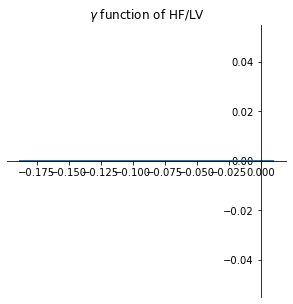

In [16]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()

# seaborn.despine(ax=ax, offset=0) # the important part here
ax.plot(gammaE.real, gammaE.imag)

# set the x-spine (see below for more info on `set_position`)
ax.spines['left'].set_position('zero')

# turn off the right spine/ticks
ax.spines['right'].set_color('none')
ax.yaxis.tick_left()

# set the y-spine
ax.spines['bottom'].set_position('zero')

# turn off the top spine/ticks
ax.spines['top'].set_color('none')
plt.title('$\gamma$ function of HF/LV')
ax.xaxis.tick_bottom();

In [7]:
gamabs = np.abs(gamma)

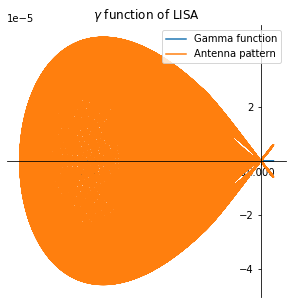

In [23]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()

# seaborn.despine(ax=ax, offset=0) # the important part here
ax.plot(gammaE.real, gammaE.imag, label='Gamma function')

ax2 = fig.add_subplot()
ax2.plot(antE.real, antE.imag, label='Antenna pattern')

#plt.plot(expfac.real, expfac.imag, label='Exponential factor')
plt.legend()

# set the x-spine (see below for more info on `set_position`)
ax.spines['left'].set_position('zero')

# turn off the right spine/ticks
ax.spines['right'].set_color('none')
ax.yaxis.tick_left()

# set the y-spine
ax.spines['bottom'].set_position('zero')

# turn off the top spine/ticks
ax.spines['top'].set_color('none')
plt.title('$\gamma$ function of LISA')
ax.xaxis.tick_bottom()
plt.legend()
plt.show();

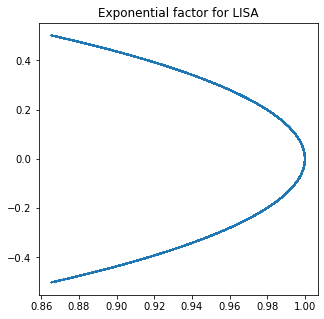

In [9]:
plt.figure(figsize=(5, 5))
plt.title("Exponential factor for LISA")
plt.plot(expfac.real, expfac.imag);

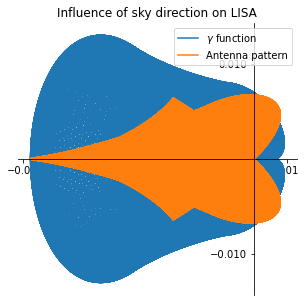

In [11]:
fig = plt.figure(figsize=(5, 5))

ax = fig.add_subplot()
ax.plot(gamma.real, gamma.imag, label='$\gamma$ function')
ax.spines['left'].set_position('zero')
ax.spines['right'].set_color('none')
ax.yaxis.tick_left()
ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_color('none')
plt.title('Influence of sky direction on LISA')
ax.xaxis.tick_bottom()

ax2 = fig.add_subplot()
ax2.plot(ant.real, ant.imag, label='Antenna pattern')

#plt.plot(expfac.real, expfac.imag, label='Exponential factor')
plt.legend()
plt.show();

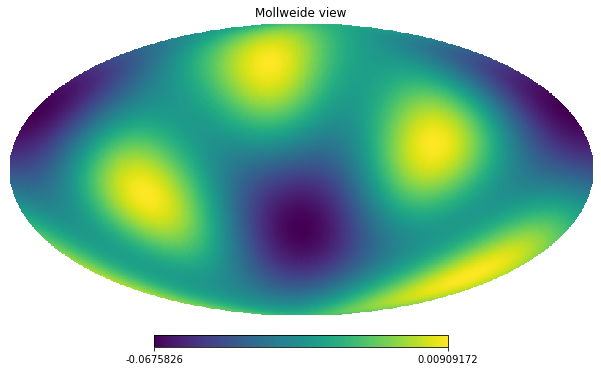

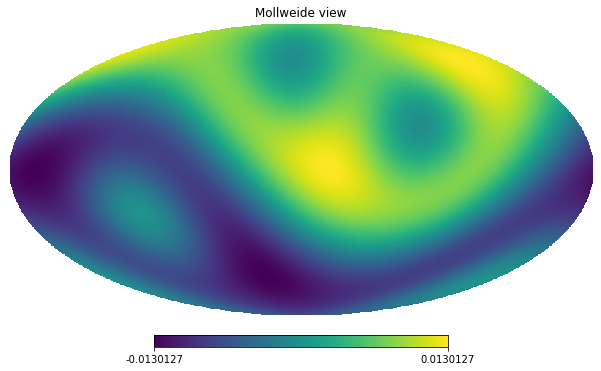

In [25]:
hp.mollview(gamma.real)
hp.mollview(gamma.imag)

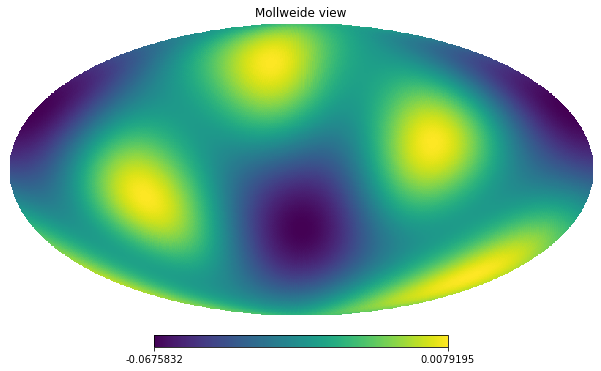

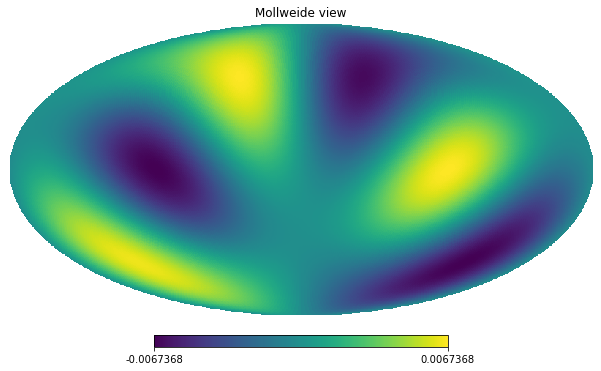

In [26]:
hp.mollview(ant.real)
hp.mollview(ant.imag)

## Verifying separation between LISA and ALIA for LISALIA

In [4]:
distances = [0.5, 0.7, 1, 1.5, 2]
lisalia_dist = np.array([[snl.LISAandALIADetector(i, separation=dist) for i in range(6)] for dist in distances])
rhoLA_dist = [snl.NoiseCorrelationLISALIA(lisalia_dist[d, 0]) for d in range(len(distances))]
mcLA_dist = [snl.MapCalculator(lisalia_dist[d], f_pivot=f_ref, corr_matrix=rhoLA_dist[d]) for d in range(len(distances))]

In [7]:
nl_dist = []
for d in range(len(distances)):
    nl_dist.append(mcLA_dist[d].get_N_ell(obs_time_T, freqs_T, nside_T, is_fspacing_log=True))
    print(f"{distances[d]} AU : done")

0.5 AU : done
0.7 AU : done
1 AU : done
1.5 AU : done
2 AU : done


2.6801187341875323e-33
2.679270833198014e-33
2.678622437105783e-33
2.680561493689642e-33
2.678622300441055e-33


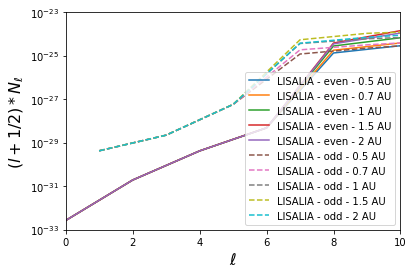

In [26]:
ls = np.arange(3 * nside_T)

plt.figure()
for d in range(len(distances)):
    print(nl_dist[d][0] / 2)
    plt.plot(ls[::2], ((ls+.5) *nl_dist[d])[::2], label=f"LISALIA - even - {distances[d]} AU")
for d in range(len(distances)):
    plt.plot(ls[1::2], ((ls+.5) *nl_dist[d])[1::2], '--', label=f"LISALIA - odd - {distances[d]} AU")
plt.yscale("log")
plt.xlabel(r'$\ell$', fontsize=16)
plt.ylabel(r'$(l+1/2) * N_\ell$', fontsize=16)
plt.xlim(0, 10)
plt.ylim(1e-33, 1e-23)
plt.legend()
plt.show();

In [ ]:
for d in range(len(distances)):
    print(nl_dist[d][0] / 2)

## Checking LISA and ALIA combination

In [4]:
obs_time_T = 4 * 365*24*3600
freqs_T = np.geomspace(1e-4, 1, 21)
nside_T = 32

nlLA = mcLA.get_N_ell(obs_time_T, freqs_T, nside_T, is_fspacing_log=True,
                      proj={'vectors': np.ones(6),
                            'deproject': True})
print("LISA and ALIA done")
nlL = mcL.get_N_ell(obs_time_T, freqs_T, nside_T, is_fspacing_log=True,
                      proj={'vectors': np.ones(3),
                            'deproject': True})
print("LISA done")
nlA = mcA.get_N_ell(obs_time_T, freqs_T, nside_T, is_fspacing_log=True,
                      proj={'vectors': np.ones(3),
                            'deproject': True})
print("ALIA done")

LISA and ALIA done
LISA done
ALIA done


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


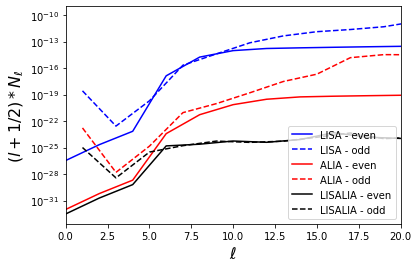

In [5]:
# Plotting time!
ls = np.arange(3 * nside_T)
plt.figure()
plt.plot(ls[::2], (ls[::2]+0.5) * nlL[::2], 'b-', label='LISA - even')
plt.plot(ls[1::2], (ls[:1:2]+0.5) * nlL[1::2], 'b--', label='LISA - odd')

plt.plot(ls[::2], (ls[::2]+0.5) * nlA[::2], 'r-', label='ALIA - even')
plt.plot(ls[1::2], (ls[1::2]+0.5) * nlA[1::2], 'r--', label='ALIA - odd')

plt.plot(ls[::2], (ls[::2]+0.5) * nlLA[::2], 'k-', label='LISALIA - even')
plt.plot(ls[1::2], (ls[1::2]+0.5) * nlLA[1::2], 'k--', label='LISALIA - odd')
plt.xlim([0, 20])
#plt.ylim([5E-34, 5E-14])
plt.legend(loc='lower right')
plt.xlabel(r'$\ell$', fontsize=16)
plt.ylabel(r'$(l+1/2) * N_\ell$', fontsize=16)
plt.yscale('log');

In [ ]:
pi_LISA = mcL.get_pi_curve(obs_time, freqs, nside,
                          is_fspacing_log=True,
                          nsigma=5, proj={'vectors': np.ones(3),
                                          'deproject': True})
print("LISA done")
pi_ALIA = mcA.get_pi_curve(obs_time, freqs, nside,
                          is_fspacing_log=True,
                          nsigma=5, proj={'vectors': np.ones(3),
                                          'deproject': True})
print("ALIA done")
pi_LISALIA = mcLA.get_pi_curve(obs_time, freqs, nside,
                          is_fspacing_log=True,
                          nsigma=5, proj={'vectors': np.ones(3),
                                          'deproject': True})
print("LISALIA done")

In [ ]:
# Plotting
h_sq = (0.67 * 0.67)
plt.plot(freqs, pi_LISALIA, 'k', label='LISALIA')
plt.plot(freqs, pi_LISA , 'k--', label='LISA 2.5Gm')
plt.plot(freqs, pi_ALIA, 'g', label='ALIA')
plt.loglog()
plt.xlabel(r'$f\,[{\rm Hz}]$', fontsize=16)
#plt.ylabel(r'$h^2 \Omega_{\rm GW}(f)$', fontsize=16)
plt.ylabel(r'$\Omega_{\rm GW}(f)$', fontsize=16)
plt.legend(loc='upper left', fontsize='x-large', frameon=False)
plt.gca().tick_params(labelsize="large")
plt.grid()
plt.show();

## Trying with shifted frequency range

In [17]:
obs_time_T = 4 * 365*24*3600
freqs_T = np.geomspace(1e-4, 1, 201)
nside_T = 32


nlLO_fshift = mcLO.get_N_ell(obs_time_T, 0.5 * freqs_T, nside_T, is_fspacing_log=True,
                      proj={'vectors': np.ones(3),
                            'deproject': True})
print("LISA old done")
nlL_fshift = mcL.get_N_ell(obs_time_T, freqs_T, nside_T, is_fspacing_log=True,
                      proj={'vectors': np.ones(3),
                            'deproject': True})
print("LISA done")
nlA_fshift = mcA.get_N_ell(obs_time_T, 5 * freqs_T, nside_T, is_fspacing_log=True,
                      proj={'vectors': np.ones(3),
                            'deproject': True})
print("ALIA done")

LISA old done
LISA done
ALIA done


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


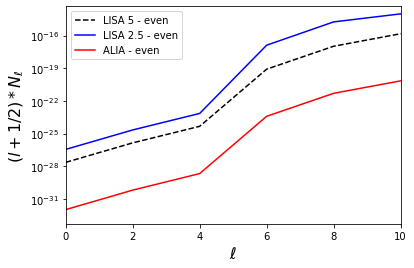

In [5]:
# Plotting time!
ls = np.arange(3 * nside_T)
plt.figure()

plt.plot(ls[::2], (ls[::2]+0.5) * nlLO_fshift[::2], 'k--', label='LISA 5 - even')
plt.plot(ls[::2], (ls[::2]+0.5) * nlL_fshift[::2], 'b-', label='LISA 2.5 - even')
#plt.plot(ls[1::2], (ls[1::2]+0.5) * nlL_fshift[1::2], 'b--', label='LISA 2.5 - odd')
plt.plot(ls[::2], (ls[::2]+0.5) * nlA_fshift[::2], 'r-', label='ALIA - even')
#plt.plot(ls[1::2], (ls[1::2]+0.5) * nlA_fshift[1::2], 'r--', label='ALIA - odd')
plt.xlim([0, 10])
plt.ylim([5E-34, 5E-14])
plt.legend(loc='upper left')
plt.xlabel(r'$\ell$', fontsize=16)
plt.ylabel(r'$(l+1/2) * N_\ell$', fontsize=16)
plt.yscale('log');

In [6]:
np.sqrt(nlL_fshift[0] / nlA_fshift[0])

587.2910677128298

## Frequency dependency of antenna pattern

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


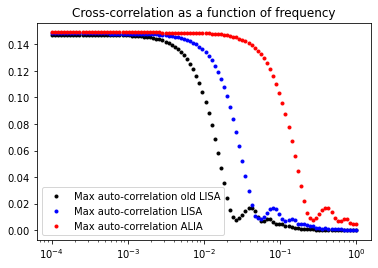

In [5]:
f_verif = np.geomspace(1e-4, 1, 11)
maxautoLO = [np.max(np.abs(mcLO.get_antenna(i=0, j=0, t=0., f=fr, theta=theta, phi=phi,
                    inc_baseline=True))) for fr in freq_low]
maxautoL = [np.max(np.abs(mcL.get_antenna(i=0, j=0, t=0., f=fr, theta=theta, phi=phi,
                    inc_baseline=True))) for fr in freq_low]
maxautoA = [np.max(np.abs(mcA.get_antenna(i=0, j=0, t=0., f=fr, theta=theta, phi=phi,
                    inc_baseline=True))) for fr in freq_low]
plt.plot(freq_low, maxautoLO, 'k.', label='Max auto-correlation old LISA')
plt.plot(freq_low, maxautoL, 'b.', label='Max auto-correlation LISA')
plt.plot(freq_low, maxautoA, 'r.', label='Max auto-correlation ALIA')
plt.legend()
plt.title('Cross-correlation as a function of frequency')
plt.xscale('log')
plt.show();
# Same curve, factor 5 in frequency

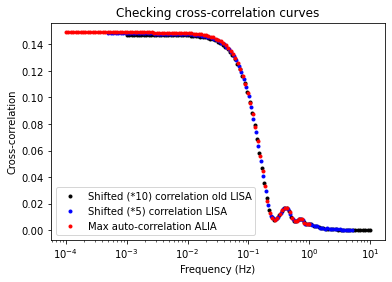

In [6]:
plt.plot(10 * freq_low, maxautoLO, 'k.', label='Shifted (*10) correlation old LISA')
plt.plot(5 * freq_low, maxautoL, 'b.', label='Shifted (*5) correlation LISA')
plt.plot(freq_low, maxautoA, 'r.', label='Max auto-correlation ALIA')
plt.title('Checking cross-correlation curves')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Cross-correlation')
plt.legend()
plt.xscale('log')
plt.show();

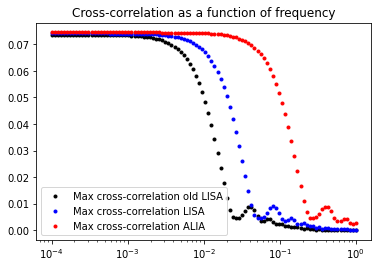

In [9]:
maxcrossLO = [np.max(np.abs(mcLO.get_antenna(i=0, j=1, t=0., f=fr, theta=theta, phi=phi,
                    inc_baseline=True))) for fr in freq_low]
maxcrossL = [np.max(np.abs(mcL.get_antenna(i=0, j=1, t=0., f=fr, theta=theta, phi=phi,
                    inc_baseline=True))) for fr in freq_low]
maxcrossA = [np.max(np.abs(mcA.get_antenna(i=0, j=1, t=0., f=fr, theta=theta, phi=phi,
                    inc_baseline=True))) for fr in freq_low]
plt.plot(freq_low, maxcrossLO, 'k.', label='Max cross-correlation old LISA')
plt.plot(freq_low, maxcrossL, 'b.', label='Max cross-correlation LISA')
plt.plot(freq_low, maxcrossA, 'r.', label='Max cross-correlation ALIA')
plt.legend()
plt.title('Cross-correlation as a function of frequency')
plt.xscale('log')
plt.show();

## Verifying scaling with $f_{ref}$

In [10]:
mcL_frefdiff = snl.MapCalculator(lisa, f_pivot=10 * f_ref,
                       corr_matrix=rhoL)
obs_time_T = 4 * 365*24*3600
freqs_T = np.geomspace(1e-4, 1, 201)
nside_T = 32


nlL = mcL.get_N_ell(obs_time_T, freqs_T, nside_T, is_fspacing_log=True,
                      proj={'vectors': np.ones(3),
                            'deproject': True})
print("LISA done")
nlL_frefdiff = mcL_frefdiff.get_N_ell(obs_time_T, freqs_T, nside_T, is_fspacing_log=True,
                      proj={'vectors': np.ones(3),
                            'deproject': True})
print("LISA done")

LISA done
LISA done


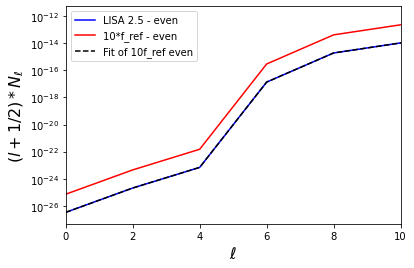

In [13]:
# Plotting time!
ls = np.arange(3 * nside_T)
plt.figure()

plt.plot(ls[::2], (ls[::2]+0.5) * nlL[::2], 'b-', label='LISA 2.5 - even')
plt.plot(ls[::2], (ls[::2]+0.5) * nlL_frefdiff[::2], 'r-', label='10*f_ref - even')
plt.plot(ls[::2], 10**(-4/3) * (ls[::2]+0.5) * nlL_frefdiff[::2], 'k--',
         label='Fit of 10f_ref even')

plt.xlim([0, 10])
plt.ylim([5E-28, 5E-12])
plt.legend(loc='upper left')
plt.xlabel(r'$\ell$', fontsize=16)
plt.ylabel(r'$(l+1/2) * N_\ell$', fontsize=16)
plt.yscale('log');

## Antenna Pattern

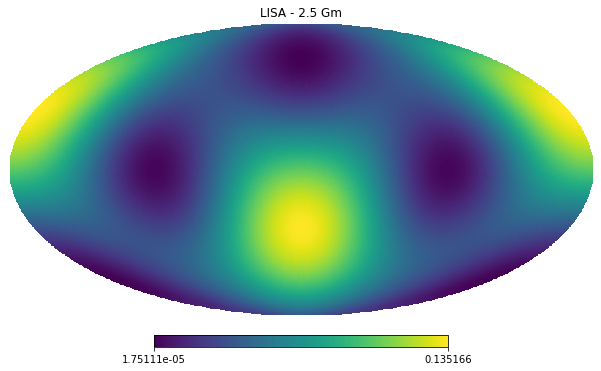

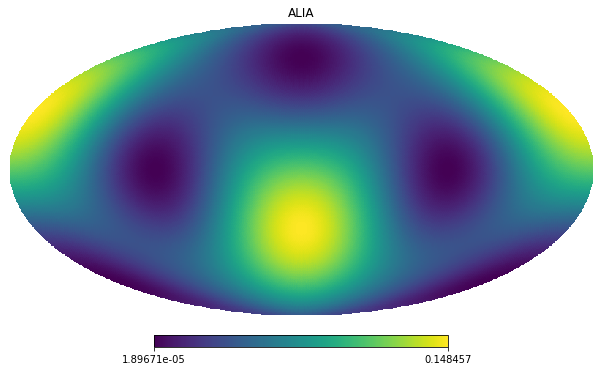

In [15]:
# i and j here are the indices of the two detectors we are correlating
antennaL = np.abs(mcL.get_antenna(i=0, j=0, t=0., f=1e-2,
                                      theta=theta, phi=phi,
                                  inc_baseline=True))
antennaA = np.abs(mcA.get_antenna(i=0, j=0, t=0., f=1e-2,
                                      theta=theta, phi=phi,
                                  inc_baseline=True))
# Plot!
# hp.mollview(antenna_start)
hp.mollview(antennaL, title="LISA - 2.5 Gm")
hp.mollview(antennaA, title="ALIA")
plt.show()

## PSD of LISA / ALIA

In [7]:
print(snl.LISADetector(0).psd_A(freq_low)[-1] / snl.ALIADetector(0).psd_A(freq_low)[-1])
print(snl.ALIADetector(0).psd_A(freq_low)[-1])

39999.97446605133
3.600002298293748e-45


In [18]:
snl.LISADetector(0).psd_X(freq_low)[-1]/snl.ALIADetector(0).psd_X(freq_low)[-1]

43025.852782807764

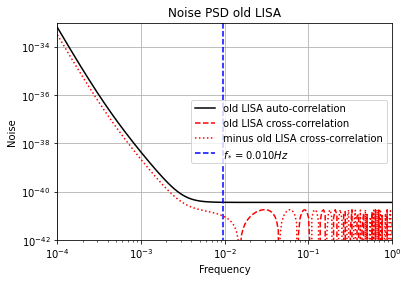

In [19]:
fstarLO = snl.LISADetector(0, is_L5Gm=True).clight / (2*np.pi*snl.LISADetector(0, is_L5Gm=True).L)
plt.figure()
plt.plot(freq_low_precise, snl.LISADetector(0, is_L5Gm=True).psd_A(freq_low_precise), 'k', label='old LISA auto-correlation')
plt.plot(freq_low_precise, snl.LISADetector(0, is_L5Gm=True).psd_X(freq_low_precise), 'r--', label='old LISA cross-correlation')
plt.plot(freq_low_precise, -snl.LISADetector(0, is_L5Gm=True).psd_X(freq_low_precise), 'r:', label='minus old LISA cross-correlation')
plt.plot(fstarLO* np.ones(51), np.geomspace(1e-47, 1e-33, 51), 'b--', label=r'$f_* = {:.3f} Hz$'.format(fstarLO))
plt.loglog()
plt.xlim(1e-4, 1)
plt.ylim(1e-42, 1e-33)
plt.title('Noise PSD old LISA')
plt.legend()
plt.grid()
plt.xlabel('Frequency')
plt.ylabel('Noise');

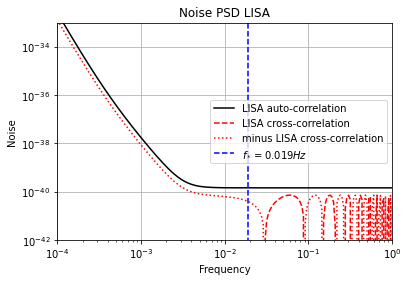

In [20]:
fstarL = snl.LISADetector(0).clight / (2*np.pi*snl.LISADetector(0).L)
plt.figure()
plt.plot(freq_low_precise, snl.LISADetector(0).psd_A(freq_low_precise), 'k', label='LISA auto-correlation')
plt.plot(freq_low_precise, snl.LISADetector(0).psd_X(freq_low_precise), 'r--', label='LISA cross-correlation')
plt.plot(freq_low_precise, -snl.LISADetector(0).psd_X(freq_low_precise), 'r:', label='minus LISA cross-correlation')
plt.plot(fstarL * np.ones(51), np.geomspace(1e-47, 1e-33, 51), 'b--', label=r'$f_* = {:.3f} Hz$'.format(fstarL))
plt.loglog()
plt.xlim(1e-4, 1)
plt.ylim(1e-42, 1e-33)
plt.title('Noise PSD LISA')
plt.legend()
plt.grid()
plt.xlabel('Frequency')
plt.ylabel('Noise');

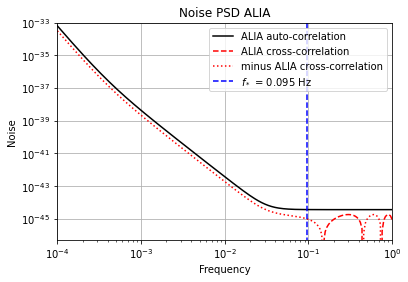

In [21]:
fstarA = snl.ALIADetector(0).clight / (2*np.pi*snl.ALIADetector(0).L)

plt.figure()
plt.plot(freq_low_precise, snl.ALIADetector(0).psd_A(freq_low_precise), 'k', label='ALIA auto-correlation')
plt.plot(freq_low_precise, snl.ALIADetector(0).psd_X(freq_low_precise), 'r--', label='ALIA cross-correlation')
plt.plot(freq_low_precise, -snl.ALIADetector(0).psd_X(freq_low_precise), 'r:', label='minus ALIA cross-correlation')
plt.plot(fstarA * np.ones(51), np.geomspace(1e-47, 1e-33, 51), 'b--', label=r'$f_*$ = {:.3f} Hz'.format(fstarA))
plt.loglog()
plt.title('Noise PSD ALIA')
plt.xlim(1e-4, 1)
plt.ylim(5e-47, 1e-33)
plt.legend()
plt.grid()
plt.xlabel('Frequency')
plt.ylabel('Noise');

## Monopole curve

In [5]:
"""
pi_LISA_old = mcLO.get_pi_curve(obs_time, freqs, nside,
                          is_fspacing_log=True,
                          nsigma=5, proj={'vectors': np.ones(3),
                                          'deproject': True})
print("LISA old done")
"""
pi_LISA = mcL.get_pi_curve(obs_time, freqs, nside,
                          is_fspacing_log=True,
                          nsigma=5, proj={'vectors': np.ones(3),
                                          'deproject': True})
print("LISA done")
"""
pi_ALIA = mcA.get_pi_curve(obs_time, freqs, nside,
                          is_fspacing_log=True,
                          nsigma=5, proj={'vectors': np.ones(3),
                                          'deproject': True})
print("ALIA done")
"""
"""
pi_BBO_Star = mcS.get_pi_curve(obs_time, freqs, nside,
                          is_fspacing_log=True,
                          nsigma=5, proj={'vectors': np.ones(6),
                                          'deproject': True})
print("BBO Star done")
""";

In [ ]:
# Plotting
h_sq = (0.67 * 0.67)
plt.plot(freqs, pi_LISA_old, 'k', label='LISA 5Gm')
plt.plot(freqs, pi_LISA , 'k--', label='LISA 2.5Gm')
plt.plot(freqs, pi_ALIA, 'g', label='ALIA')
"""plt.plot(freqs, pi_BBO_Star * h_sq, 'y', label='BBO_Star')"""
plt.loglog()
plt.xlabel(r'$f\,[{\rm Hz}]$', fontsize=16)
#plt.ylabel(r'$h^2 \Omega_{\rm GW}(f)$', fontsize=16)
plt.ylabel(r'$\Omega_{\rm GW}(f)$', fontsize=16)
plt.legend(loc='upper left', fontsize='x-large', frameon=False)
plt.gca().tick_params(labelsize="large")
plt.grid()
plt.show(); 

## Noise power spectra

In [4]:
obs_time_T = 4 * 365*24*3600
freqs_T = np.geomspace(1e-4, 1, 201)
nside_T = 32

"""
nlLO = mcLO.get_N_ell(obs_time_T, freqs_T, nside_T, is_fspacing_log=True,
                      proj={'vectors': np.ones(3),
                            'deproject': True})
print("LISA old done")"""
nlL = mcL.get_N_ell(obs_time_T, freqs_T, nside_T, is_fspacing_log=True,
                      proj={'vectors': np.ones(3),
                            'deproject': True})
print("LISA done")
nlA = mcA.get_N_ell(obs_time_T, freqs_T, nside_T, is_fspacing_log=True,
                      proj={'vectors': np.ones(3),
                            'deproject': True})
print("ALIA done")
"""nlS = mcS.get_N_ell(obs_time_T, freqs_T, nside_T, no_autos=True)
print("BBO Star done")""";

LISA done
ALIA done


In [6]:
nlL_all = mcL.get_N_ell(obs_time_T, freqs_T, nside_T, is_fspacing_log=True)

In [20]:
mcA_newf = snl.MapCalculator(alia, f_pivot=10 * f_ref,
                       corr_matrix=rhoA)
nlA_newf = mcA_newf.get_N_ell(obs_time_T, freqs_T, nside_T, is_fspacing_log=True,
                      proj={'vectors': np.ones(3),
                            'deproject': True})

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


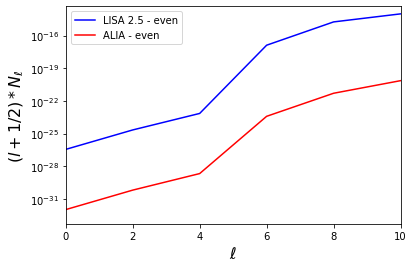

In [8]:
# Plotting time!
ls = np.arange(3 * nside_T)
plt.figure()

plt.plot(ls[::2], (ls[::2]+0.5) * nlL[::2], 'b-', label='LISA 2.5 - even')
#plt.plot(ls[1::2], (ls[1::2]+0.5) * nlL[1::2], 'b--', label='LISA 2.5 - odd')
#plt.plot(ls[1::2], (ls[1::2]+0.5) * nlL_all[1::2], 'b-.', label='LISA 2.5 - odd - all data')
plt.plot(ls[::2], (ls[::2]+0.5) * nlA[::2], 'r-', label='ALIA - even')
#plt.plot(ls[1::2], (ls[1::2]+0.5) * nlA[1::2], 'r--', label='ALIA - odd')
#plt.plot(ls[::2],(ls[::2]+0.5) * nlA_newf[::2], 'k--', label='ALIA new f - even')
#plt.plot(ls[::2], (ls[::2]+0.5) * nlLA[::2], 'k--', label='LISALIA - even')
plt.xlim([0, 10])
plt.ylim([5E-34, 5E-14])
plt.legend(loc='upper left')
plt.xlabel(r'$\ell$', fontsize=16)
plt.ylabel(r'$(l+1/2) * N_\ell$', fontsize=16)
plt.yscale('log');

In [9]:
plt.plot(nlL[::2] / nlA_newf[::2], '.')

NameError: name 'nlA_newf' is not defined

In [ ]:
(nlL[0] / nlA_newf[0])**(0.25)

In [9]:
(nlL[0] / nlA[0]) / 644063.1106488033

0.5355232949714576

In [ ]:
1.5 * nlL_all[1]
#computed value: 3.0876e-21

In [ ]:
print(0.5 * nlL[0])
print(0.5 * nlA[0] * 24**4)

## Sensitivities for LISA / ALIA

In [9]:
freq_low = np.geomspace(1e-4, 1, 201)
full_compute = True

In [10]:
sensLO = lisa_old[0].sensitivity(freq_low, full_compute=full_compute)
print("Old LISA done")
sensL = lisa[0].sensitivity(freq_low, full_compute=full_compute)
print("LISA done")
sensA = alia[0].sensitivity(freq_low, full_compute=full_compute)
print("ALIA done")

strainLO = np.sqrt(freq_low * sensLO)
strainL = np.sqrt(freq_low * sensL)
strainA = np.sqrt(freq_low * sensA)

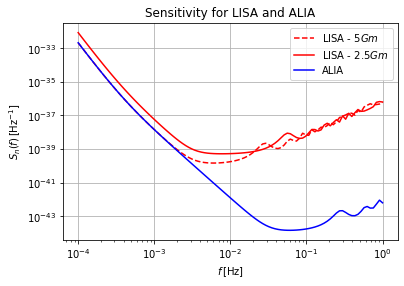

In [11]:
plt.plot(freq_low, sensLO, 'r--', label="LISA - $5 Gm$")
plt.plot(freq_low, sensL, 'r', label="LISA - $2.5 Gm$")
plt.plot(freq_low, sensA, 'b', label="ALIA")

plt.title("Sensitivity for LISA and ALIA")
plt.legend()
plt.xlabel(r'$f\,[{\rm Hz}]$')
plt.ylabel(r'$S_n(f)\,[{\rm Hz}^{-1}]$')
#plt.ylabel(r'$h_c$')
plt.loglog()
plt.grid()
plt.show()

In [ ]:
print(np.min(strainL) / np.min(strainA))
print(np.min(strainA))

## Response function of LISA / ALIA

In [ ]:
respLO = lisa_old[0].response(freq_low)
print("LISA old done")
respL = lisa[0].response(freq_low)
print("LISA done")
respA = alia[0].response(freq_low)
print("ALIA done")

In [ ]:
def fit(freq, detector):
    fstar = detector.clight / (2*np.pi*detector.L)
    return 3/10 / (1 + 0.6*(freq/fstar)**2)
fitLO = fit(freq_low, lisa_old[0])
fitL = fit(freq_low, lisa[0])
fitA = fit(freq_low, alia[0])

In [ ]:
plt.plot(freq_low, respLO, 'k', label="LISA 5")
plt.plot(freq_low, respL, 'r', label="LISA 2.5")
plt.plot(freq_low, respA, 'b', label="ALIA")
plt.plot(freq_low, fitLO, 'k-.', label="Fit for LISA 5")
plt.plot(freq_low, fitL, 'y-.', label="Fit for LISA 2.5")
plt.plot(freq_low, fitA, 'g-.', label="Fit for ALIA")

plt.title("Response functions of LISA / ALIA and approximations")
plt.legend()
plt.xlabel(r'$f\,[{\rm Hz}]$')
plt.ylabel(r'$R(f)$')
plt.loglog()
plt.grid()
plt.show()

## Galactic confusion noise

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


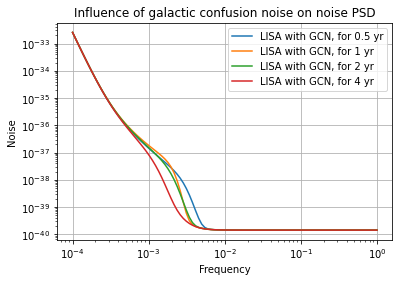

In [5]:
durations = [0.5,1,2,4]
lisa_gcn = [snl.LISADetector(0, include_GCN=True, mission_duration=i) for i in durations]

plt.figure()
for i in range(4):
    plt.plot(freq_low, lisa_gcn[i].psd(freq_low), label='LISA with GCN, for {} yr'.format(durations[i]))
plt.loglog()
plt.title('Influence of galactic confusion noise on noise PSD')
plt.legend()
plt.grid()
plt.xlabel('Frequency')
plt.ylabel('Noise');

## Tests -- BBO Star position

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

# First let's get the spacecraft positions throughout the year
t_arr = np.arange(0, 365*24*3600, 5*24*3600)  #180 * 24*3600
pos_star = np.array([l.get_position(t_arr) for l in star])

# Now let's plot them
from mpl_toolkits.mplot3d import Axes3D

# We'll plot things in units of 1 A.U.
R_AU = star[0].R_AU

fig = plt.figure()
ax = fig.gca(projection='3d')
for ip, p in enumerate(pos_star):
    ax.plot(p[0] / R_AU, p[1] / R_AU, p[2] / R_AU, '.',
            label=r'$%d$' % (ip+1),
            markersize=5) #label=r'${\rm %d-th\,\,spacecraft}$' % (ip+1)
limm = 1e-3
ax.set_zlim([-limm, limm])
ax.legend();

In [ ]:
# Relative positions
dx01 = pos_star[1]-pos_star[0]
dx12 = pos_star[2]-pos_star[1]
dx23 = pos_star[3]-pos_star[2]

l01 = np.sqrt(np.sum(dx01**2, axis=0))
l12 = np.sqrt(np.sum(dx12**2, axis=0))
l23 = np.sqrt(np.sum(dx23**2, axis=0))

mean_len = np.sum(l01) / len(l01)

# Lengths
yr = 365*24*3600
plt.figure()
plt.plot(t_arr / yr, l01/mean_len*100, label=r'$L_{01}$')
plt.plot(t_arr / yr, l12/mean_len*100, label=r'$L_{12}$')
plt.plot(t_arr / yr, l23/mean_len*100, label=r'$L_{23}$')
plt.xlabel(r'$t\,[{\rm yrs}]$', fontsize=16)
plt.ylabel(r'$L_{ij} / (5\times 10^7 m) \%$', fontsize=16)
plt.legend();